#  Importamos liberias

In [108]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
from statsmodels.stats.diagnostic import het_arch
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR


# Lectura de datos

In [2]:
dataset = pd.read_excel('DatoseTmperaturaMaximaDiariaMedellin2000_2024.xlsx', skiprows=7)

# Clase 1

In [3]:
dataset['Year'] = pd.to_datetime(dataset['Fecha']).dt.year
dataset['Returns'] = dataset['Temperatura'].diff()

Hallamos los retornos

In [9]:
differences = pd.DataFrame()
differences['Returns'] = np.log(dataset['Temperatura']).diff()
differences['Year'] = dataset['Year']
differences

,Returns,Year
0,NaN,2000
1,-0.028573,2000
2,-0.021979,2000
3,-0.007435,2000
4,-0.022642,2000
...,...,...
8435,-0.145852,2024
8436,0.098311,2024
8437,-0.007519,2024
8438,-0.082562,2024


In [10]:
final_dataset = differences.groupby(['Year'])['Returns'].aggregate(['mean', 'std']).reset_index()

In [ ]:
plt

Hallamos la media y la desviacion estandar

In [12]:
final_dataset

,Year,mean,std
0,2000,0.000114,0.074256
1,2001,0.000019,0.079160
2,2002,-0.000161,0.076271
3,2003,-0.000089,0.077799
4,2004,0.000010,0.075675
5,2005,0.000203,0.074481
6,2006,-0.000233,0.072843
7,2007,0.000158,0.076342
8,2008,-0.000019,0.076431
9,2009,0.000132,0.067424


In [15]:
differences['Returns']

0            NaN
1      -0.028573
2      -0.021979
3      -0.007435
4      -0.022642
          ...   
8435   -0.145852
8436    0.098311
8437   -0.007519
8438   -0.082562
8439    0.067352
Name: Returns, Length: 8440, dtype: float64

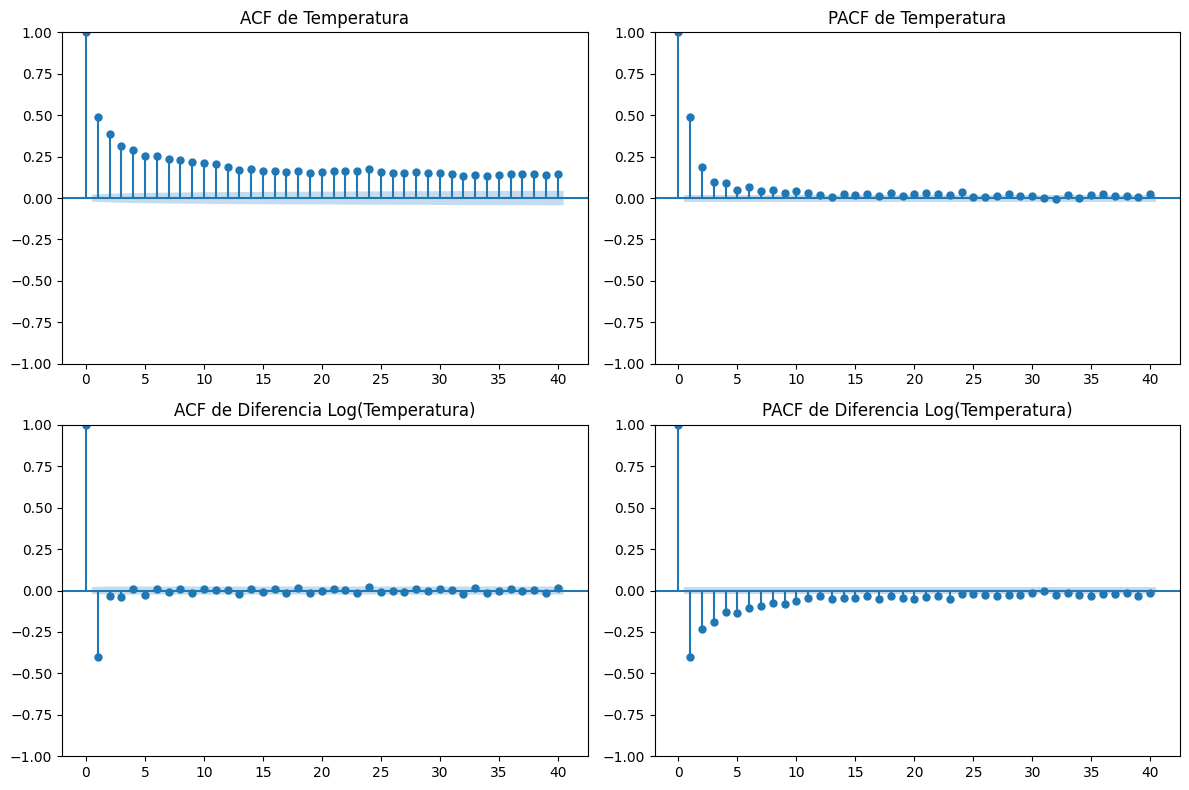

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(dataset['Temperatura'].dropna(), ax=axes[0, 0])
axes[0, 0].set_title('ACF de Temperatura')
plot_pacf(dataset['Temperatura'].dropna(), ax=axes[0, 1])
axes[0, 1].set_title('PACF de Temperatura')
 
plot_acf(differences['Returns'].dropna(), ax=axes[1, 0])
axes[1, 0].set_title('ACF de Diferencia Log(Temperatura)')
plot_pacf(differences['Returns'].dropna(), ax=axes[1, 1])
axes[1, 1].set_title('PACF de Diferencia Log(Temperatura)')
 
plt.tight_layout()
plt.show()

La correlacion de los datos decrece lentamente, por esta razon podemos asumir que los datos de temepratura no son estacionarios. Pero los datos de la diferencia logaritmica entre la temepratura si es estacionaria porque decrece rapidamente

# Clase 2

In [22]:
apple = pd.read_csv('apple_stock_2020.csv')
apple.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,02/05/2025,232.47,228.53,232.65,228.42,37.09M,-0.14%
1,02/04/2025,232.80,227.25,233.13,226.65,45.07M,2.10%
2,02/03/2025,228.01,229.99,231.83,225.70,73.06M,-3.39%
3,01/31/2025,236.00,247.19,247.19,233.44,101.08M,-0.67%
4,01/30/2025,237.59,238.66,240.79,237.21,55.66M,-0.74%


Vamos a calcular los rendimientos logaritmicos

In [25]:
apple["Date"] = pd.to_datetime(apple["Date"], format="%m/%d/%Y")
df = apple.sort_values("Date")

df["log_return"] = np.log(df["Price"] / df["Price"].shift(1))
df[["Date", "Price", "log_return"]]

,Date,Price,log_return
773,2022-01-05,174.92,NaN
772,2022-01-06,172.00,-0.016834
771,2022-01-07,172.17,0.000988
770,2022-01-10,172.19,0.000116
769,2022-01-11,175.08,0.016644
...,...,...,...
4,2025-01-30,237.59,-0.007422
3,2025-01-31,236.00,-0.006715
2,2025-02-03,228.01,-0.034442
1,2025-02-04,232.80,0.020790


Graficamos r_t y y_t

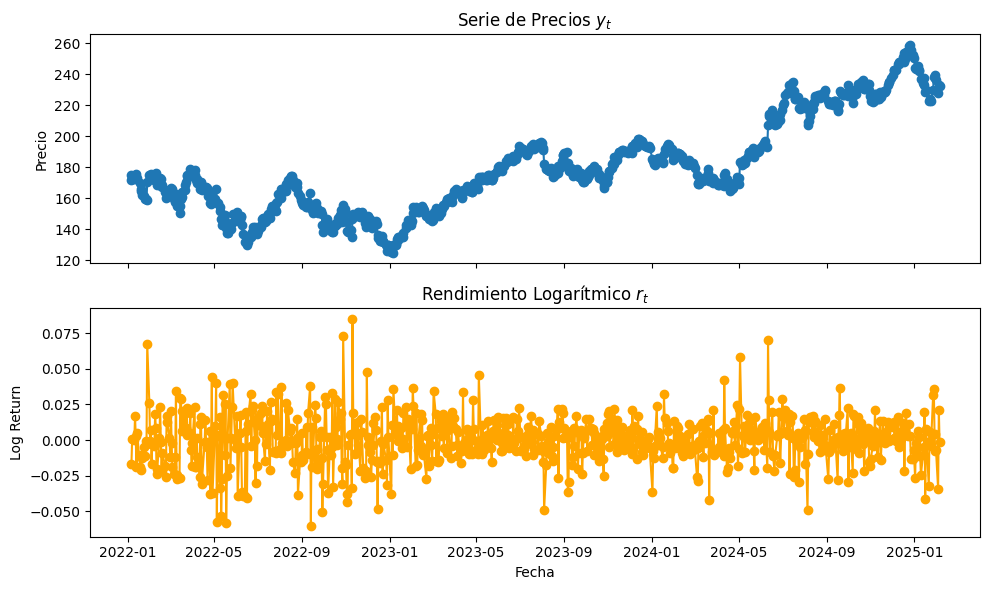

In [26]:
# Graficar y_t y r_t
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axes[0].plot(df["Date"], df["Price"], marker='o')
axes[0].set_title("Serie de Precios $y_t$")
axes[0].set_ylabel("Precio")

axes[1].plot(df["Date"], df["log_return"], marker='o', color='orange')
axes[1].set_title("Rendimiento Logarítmico $r_t$")
axes[1].set_ylabel("Log Return")
axes[1].set_xlabel("Fecha")

plt.tight_layout()
plt.show()

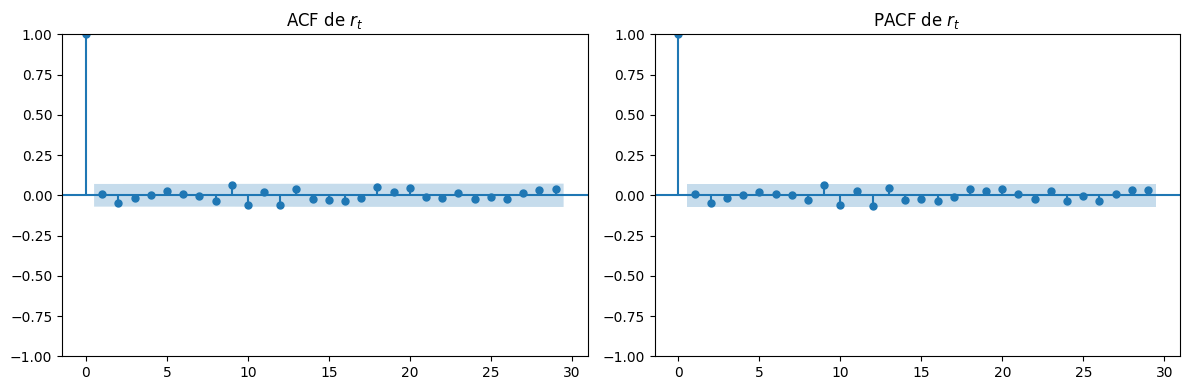

In [29]:
returns = df["log_return"].dropna()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(returns, ax=axes[0], title="ACF de $r_t$")
plot_pacf(returns, ax=axes[1], title="PACF de $r_t$", method='ywm')

plt.tight_layout()
plt.show()

Pruebas de Dickey Fuller y Philips Person

In [32]:
# Serie original
y_t = df["Price"]

# Primera diferencia logarítmica
r_t = np.log(y_t / y_t.shift(1)).dropna()

# === Dickey-Fuller Aumentada ===
print("=== ADF Test sobre y_t (Precio) ===")
adf_result_y = adfuller(y_t.dropna(), autolag='AIC')
print(f"Estadístico: {adf_result_y[0]:.4f}, p-valor: {adf_result_y[1]:.4f}")

print("\n=== ADF Test sobre r_t (Log-Retorno) ===")
adf_result_r = adfuller(r_t, autolag='AIC')
print(f"Estadístico: {adf_result_r[0]:.4f}, p-valor: {adf_result_r[1]:.4f}")

# === Phillips-Perron ===
print("\n=== Phillips-Perron Test sobre y_t (Precio) ===")
pp_y = PhillipsPerron(y_t.dropna())
print(pp_y.summary())

print("\n=== Phillips-Perron Test sobre r_t (Log-Retorno) ===")
pp_r = PhillipsPerron(r_t)
print(pp_r.summary())

=== ADF Test sobre y_t (Precio) ===
Estadístico: -0.7925, p-valor: 0.8213

=== ADF Test sobre r_t (Log-Retorno) ===
Estadístico: -20.4577, p-valor: 0.0000

=== Phillips-Perron Test sobre y_t (Precio) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -0.744
P-value                         0.835
Lags                               21
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

=== Phillips-Perron Test sobre r_t (Log-Retorno) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                -27.508
P-value                         0.000
Lags                               21
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Con estos resultados podemos observar que los precios no son estacionarios

In [33]:
# Serie original
y_t = df["Open"]

# Diferencias logarítmicas
r_t = np.log(y_t / y_t.shift(1)).dropna()

# === ADF ===
print("=== ADF Test sobre y_t (Open) ===")
adf_result_y = adfuller(y_t.dropna(), autolag='AIC')
print(f"Estadístico: {adf_result_y[0]:.4f}, p-valor: {adf_result_y[1]:.4f}")

print("\n=== ADF Test sobre r_t (Log-Retorno de Open) ===")
adf_result_r = adfuller(r_t, autolag='AIC')
print(f"Estadístico: {adf_result_r[0]:.4f}, p-valor: {adf_result_r[1]:.4f}")

# === Phillips-Perron ===
print("\n=== Phillips-Perron Test sobre y_t (Open) ===")
pp_y = PhillipsPerron(y_t.dropna())
print(pp_y.summary())

print("\n=== Phillips-Perron Test sobre r_t (Log-Retorno de Open) ===")
pp_r = PhillipsPerron(r_t)
print(pp_r.summary())

=== ADF Test sobre y_t (Open) ===
Estadístico: -0.9811, p-valor: 0.7601

=== ADF Test sobre r_t (Log-Retorno de Open) ===
Estadístico: -28.4618, p-valor: 0.0000

=== Phillips-Perron Test sobre y_t (Open) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                 -0.869
P-value                         0.798
Lags                               21
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.

=== Phillips-Perron Test sobre r_t (Log-Retorno de Open) ===
     Phillips-Perron Test (Z-tau)    
Test Statistic                -28.589
P-value                         0.000
Lags                               21
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stat

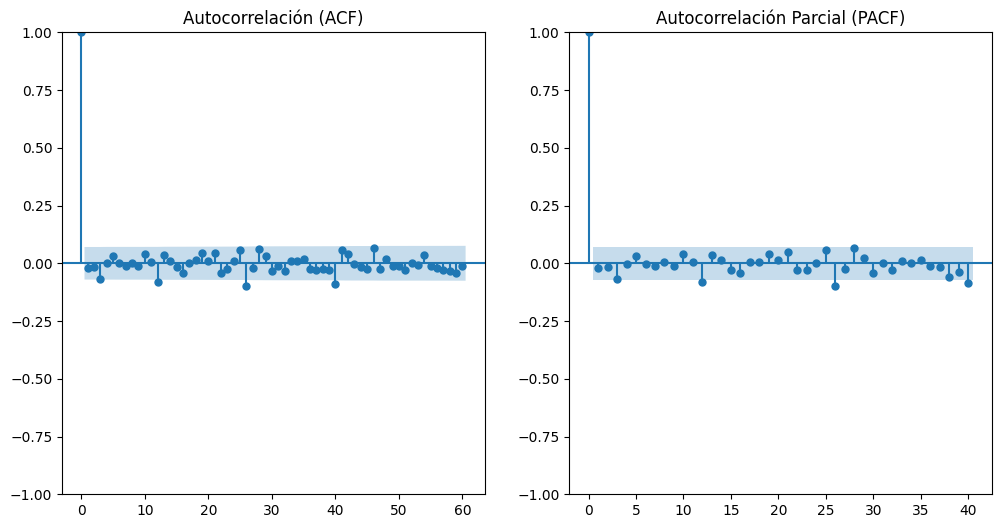

In [38]:
# Visualizar la ACF y PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ACF (Autocorrelación)
plot_acf(r_t, lags=60, ax=axes[0])
axes[0].set_title('Autocorrelación (ACF)')

# PACF (Autocorrelación Parcial)
plot_pacf(r_t, lags=40, ax=axes[1])
axes[1].set_title('Autocorrelación Parcial (PACF)')

plt.show()

Con pmax y qmax de 40

In [39]:
from statsmodels.tsa.arima.model import ARIMA
p_max = 40
q_max = 40

# Ajustar el modelo ARMA
model = ARIMA(r_t, order=(p_max, 0, q_max))  # 0 porque no tienes término I (es estacionaria)
model_fit = model.fit()

# Ver los resultados del modelo ajustado
print(model_fit.summary())


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-i

                               SARIMAX Results                                
Dep. Variable:                   Open   No. Observations:                  773
Model:               ARIMA(40, 0, 40)   Log Likelihood                2043.060
Date:                Sat, 03 May 2025   AIC                          -3922.119
Time:                        10:45:10   BIC                          -3540.796
Sample:                             0   HQIC                         -3775.395
                                - 773                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.673      0.501      -0.001       0.001
ar.L1         -0.0769      1.908     -0.040      0.968      -3.816       3.662
ar.L2         -0.0680      1.495     -0.046      0.9

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-4019.618, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4026.501, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-4024.873, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-4024.885, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4022.878, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-4024.736, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.678 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  773
Model:                        SARIMAX   Log Likelihood                2014.250
Date:                Sat, 03 May 2025   AIC                          -4026.501
Time:                        10:45:33   BIC                          -4021.850
Sample:                             0   HQIC                         -4024.711
    

/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


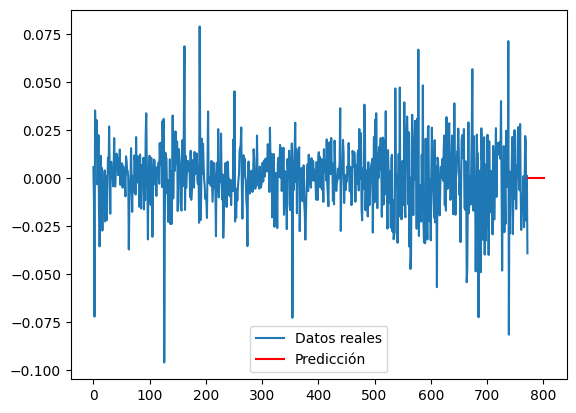

In [40]:
import pmdarima as pm
import matplotlib.pyplot as plt

# Ajustar el modelo AutoARIMA
model_auto = pm.auto_arima(r_t, 
                           seasonal=False,  # Si no tienes estacionalidad, pon esto en False
                           stepwise=True,   # Utiliza el enfoque paso a paso para optimizar los parámetros
                           trace=True)      # Muestra el progreso del ajuste

# Resumen del modelo ajustado
print(model_auto.summary())

# Realizar predicciones con el modelo ajustado
n_periods = 30  # Número de periodos a predecir
forecast = model_auto.predict(n_periods=n_periods)

# Graficar los resultados
plt.plot(r_t.index, r_t, label="Datos reales")
plt.plot(range(len(r_t), len(r_t) + n_periods), forecast, label="Predicción", color='red')
plt.legend()
plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-4019.618, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4026.501, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-4024.873, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-4024.885, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4022.878, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-4024.736, Time=0.29 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.759 seconds


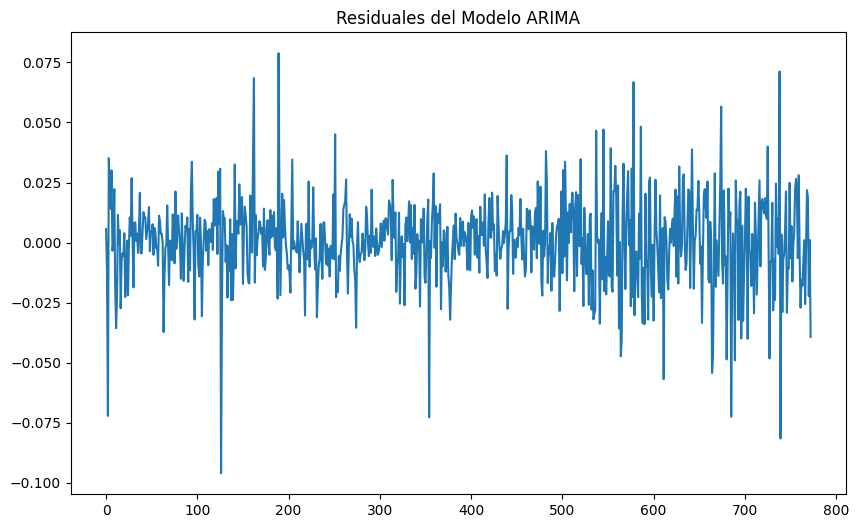

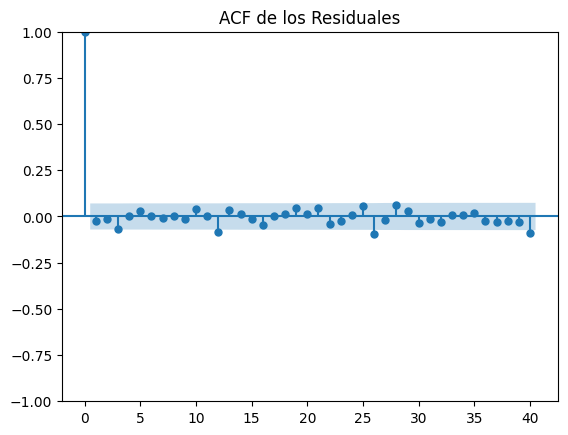

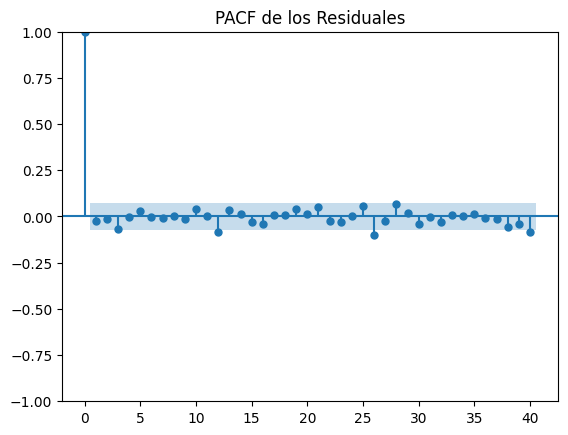

      lb_stat  lb_pvalue
40  45.317527   0.259827


In [41]:
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Ajustamos el modelo AutoARIMA
model_auto = pm.auto_arima(r_t, seasonal=False, stepwise=True, trace=True)

# Extraemos los residuales
residuals = model_auto.resid()

# 1. Graficar los residuos
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuales del Modelo ARIMA')
plt.show()

# 2. Graficar ACF de los residuales (para revisar autocorrelación)
plot_acf(residuals, lags=40)
plt.title('ACF de los Residuales')
plt.show()

# 3. Graficar PACF de los residuales (para revisar autocorrelación parcial)
plot_pacf(residuals, lags=40)
plt.title('PACF de los Residuales')
plt.show()

# 4. Realizar el Test de Ljung-Box sobre los residuales
# Verificamos si los residuales muestran autocorrelación significativa
ljung_box_result = acorr_ljungbox(residuals, lags=[40], return_df=True)
print(ljung_box_result)

# Si el p-valor es mayor a 0.05, los residuos son ruido blanco


En este caso los valores estan dentro de las bancadas de confianza, por tal razon , podemos afirmar que no hay correalcio ni correlacion parcial

# Tercera Clase

Hallamos el error cuadrado

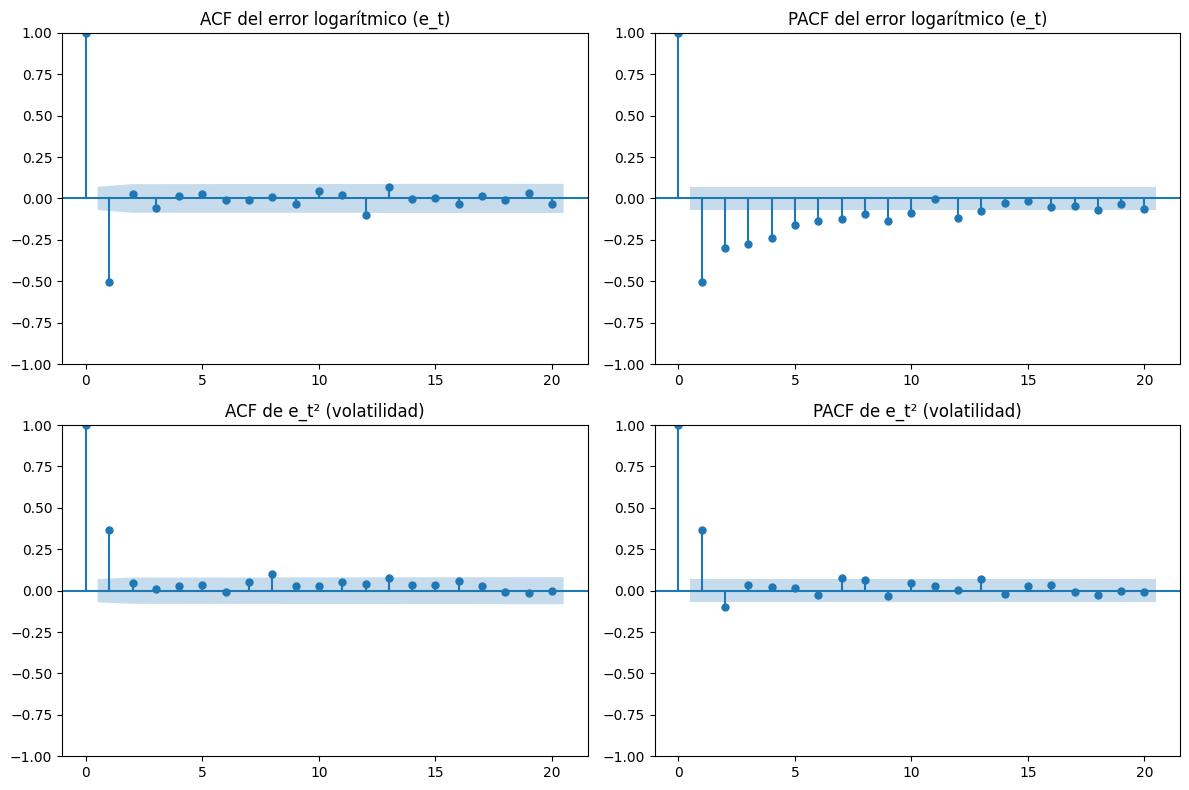

In [23]:
# 1. Leer y preparar datos
df = pd.read_csv('apple_stock_2020.csv')  # columna 'Close' y 'Date'
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 2. Calcular log-precios y log-retornos
df['log_price'] = np.log(df['Open'])
df['log_return'] = df['log_price'] - df['log_price'].shift(1)

# 3. Crear predicción (ej: usar retorno del día anterior como estimación)
df['y_t'] = df['log_return']
df['y_hat_t'] = df['log_return'].shift(1)  # predicción naive

# 4. Calcular error y su cuadrado
df['e_t'] = df['y_t'] - df['y_hat_t']
df['e_t_squared'] = df['e_t'] ** 2

# 5. Graficar ACF y PACF del error logarítmico y su cuadrado
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(df['e_t'].dropna(), ax=ax[0, 0], lags=20)
ax[0, 0].set_title('ACF del error logarítmico (e_t)')

plot_pacf(df['e_t'].dropna(), ax=ax[0, 1], lags=20)
ax[0, 1].set_title('PACF del error logarítmico (e_t)')

plot_acf(df['e_t_squared'].dropna(), ax=ax[1, 0], lags=20)
ax[1, 0].set_title('ACF de e_t² (volatilidad)')

plot_pacf(df['e_t_squared'].dropna(), ax=ax[1, 1], lags=20)
ax[1, 1].set_title('PACF de e_t² (volatilidad)')

plt.tight_layout()
plt.show()


In [29]:
df['e_t'].dropna()

Date
2025-02-03    0.017602
2025-01-31    0.060136
2025-01-30   -0.107239
2025-01-29    0.015911
2025-01-28    0.005140
                ...   
2022-01-11   -0.023745
2022-01-10    0.002831
2022-01-07    0.041265
2022-01-06   -0.023383
2022-01-05    0.040331
Name: e_t, Length: 772, dtype: float64

In [34]:
# Prueba de Engle para heterocedasticidad condicional (efectos ARCH)
arch_test_result = het_arch(df['e_t'].dropna(), nlags=5)

# Resultados
print(f'Estadístico F: {arch_test_result[0]:.4f}')
print(f'p-valor F: {arch_test_result[1]:.4f}')
print(f'Estadístico LM: {arch_test_result[2]:.4f}')
print(f'p-valor LM: {arch_test_result[3]:.4f}')

Estadístico F: 115.9784
p-valor F: 0.0000
Estadístico LM: 27.1142
p-valor LM: 0.0000


En este caso como p-valor < 0.05 rechazamos la hipotesis nula, es decir, que si hay presencia de efectos Arch sobre los datos. Por tanto, podemos usar modelos Arch o Garch para realizar analisis de volatilidad.  
Mirando el ACF y PACF podemos concluir que la cantidad de rezagos ideal es de 2, dado que son los que presentan mayor influencia sobre el valor de la variable en el tiempo t.

Vamos a ajustar un modelo GARCH(2,1) sobre los datos y lo verificaremos.

In [37]:
returns = df['log_return'].dropna() * 100
model = arch_model(returns, vol='GARCH', p=2, q=1, mean='Constant', rescale=False)
garch_fit = model.fit(disp='off')
print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1517.20
Distribution:                  Normal   AIC:                           3044.41
Method:            Maximum Likelihood   BIC:                           3067.66
                                        No. Observations:                  773
Date:                Sat, May 17 2025   Df Residuals:                      772
Time:                        15:02:16   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0722  7.057e-02     -1.023      0.306 [ -0.211,

Ahora verificaremos los residuales estandarizados del modelo para verificar que no se presente autocorrelacion en el modelo

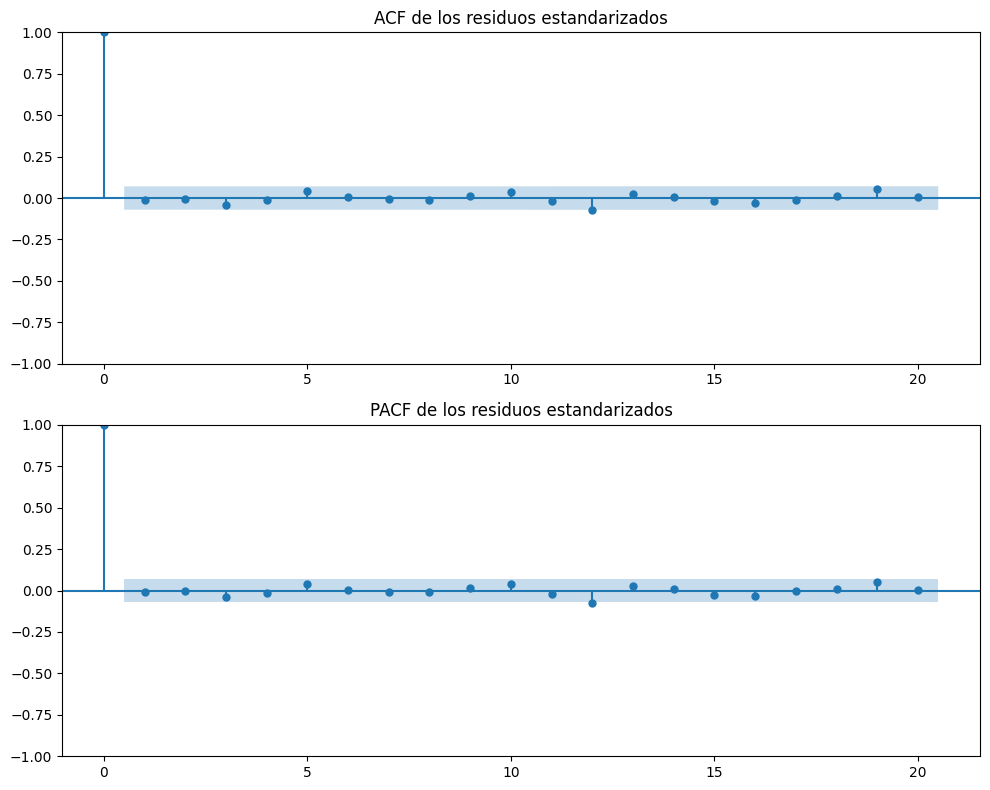

In [38]:
standardized_residuals = garch_fit.std_resid
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(standardized_residuals.dropna(), ax=ax[0], lags=20)
ax[0].set_title('ACF de los residuos estandarizados')

plot_pacf(standardized_residuals.dropna(), ax=ax[1], lags=20)
ax[1].set_title('PACF de los residuos estandarizados')

plt.tight_layout()
plt.show()

Siguiendo los resultados arrojados en el grafico anterior, podemos ver que el modelo que mejor se ajusta a los datos es el modelo GARCH(2, 1)

# Cuarta Clase

Leemos los datos, vamos a trabajar con la empresa de Apple

In [69]:
dj30 = pd.read_csv('dj30.csv')
dj30["Fecha"] = pd.to_datetime(dj30["Fecha"], format='%d.%m.%Y')

apple = pd.read_csv('apple.csv')
apple["Fecha"] = pd.to_datetime(apple["Fecha"], format='%d.%m.%Y')

nasdaq = pd.read_csv('nasdaq.csv')
nasdaq["Date"] = pd.to_datetime(nasdaq["Date"], format="%m/%d/%Y")

syp = pd.read_csv('syp500.csv')
syp["Date"] = pd.to_datetime(syp["Date"], format="%m/%d/%Y")


Ahora vamos a evaluar la estacionariedad de las 4 series

In [70]:
# Función para convertir texto en formato europeo a float
def convertir_formato_europeo(col):
    return col.str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)

# Limpiar columnas relevantes
for col in ['Último', 'Apertura', 'Máximo', 'Mínimo']:
    dj30[col] = convertir_formato_europeo(dj30[col])
    apple[col] = convertir_formato_europeo(apple[col])

def convertir_formato_europeo_serie(serie):
    return serie.astype(str).str.replace('.', '', regex=False).str.replace(',', '.', regex=False).astype(float)


nasdaq['Close'] = convertir_formato_europeo_serie(nasdaq['Close'])
syp['Close'] = convertir_formato_europeo_serie(syp['Close'])


In [73]:
# Renombramos columnas y unificamos por fecha
dj30 = dj30[['Fecha', 'Último']].rename(columns={'Último': 'DJ30'})
apple = apple[['Fecha', 'Último']].rename(columns={'Último': 'Apple'})
nasdaq = nasdaq[['Date', 'Close']].rename(columns={'Date': 'Fecha', 'Close': 'Nasdaq'})
syp = syp[['Date', 'Close']].rename(columns={'Date': 'Fecha', 'Close': 'SP500'})

# Merge de todo
df = dj30.merge(apple, on='Fecha').merge(nasdaq, on='Fecha').merge(syp, on='Fecha')
df.sort_values('Fecha', inplace=True)
df.set_index('Fecha', inplace=True)

# Log-diferencias (retornos)
log_diff_df = np.log(df).diff().dropna()



In [74]:
from statsmodels.tsa.stattools import adfuller

def evaluar_estacionariedad(serie, nombre):
    resultado = adfuller(serie.dropna())
    print(f"\n>>> {nombre}")
    print(f"ADF Statistic: {resultado[0]:.4f}")
    print(f"p-value: {resultado[1]:.4f}")
    if resultado[1] < 0.05:
        print("→ Serie estacionaria")
    else:
        print("→ Serie NO estacionaria")

# Evaluar cada serie
for col in log_diff_df.columns:
    evaluar_estacionariedad(log_diff_df[col], col)



>>> DJ30
ADF Statistic: -4.4177
p-value: 0.0003
→ Serie estacionaria

>>> Apple
ADF Statistic: -4.8578
p-value: 0.0000
→ Serie estacionaria

>>> Nasdaq
ADF Statistic: -4.3315
p-value: 0.0004
→ Serie estacionaria

>>> SP500
ADF Statistic: -4.0983
p-value: 0.0010
→ Serie estacionaria


Todas las series son estacionarias, por tanto podemos aplicar el modelo VAR.  
Primero determinaremos la cantidad optima de rezagos con las graficas de ACF y PACF

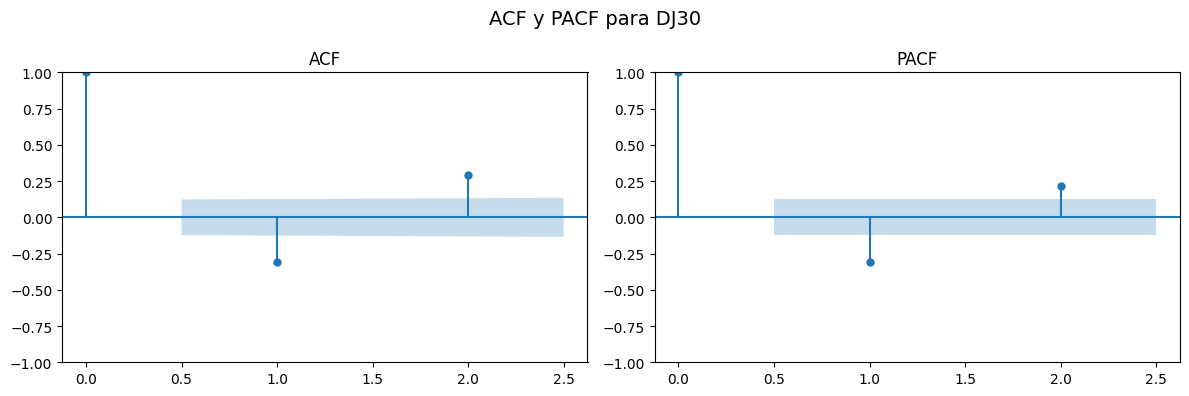

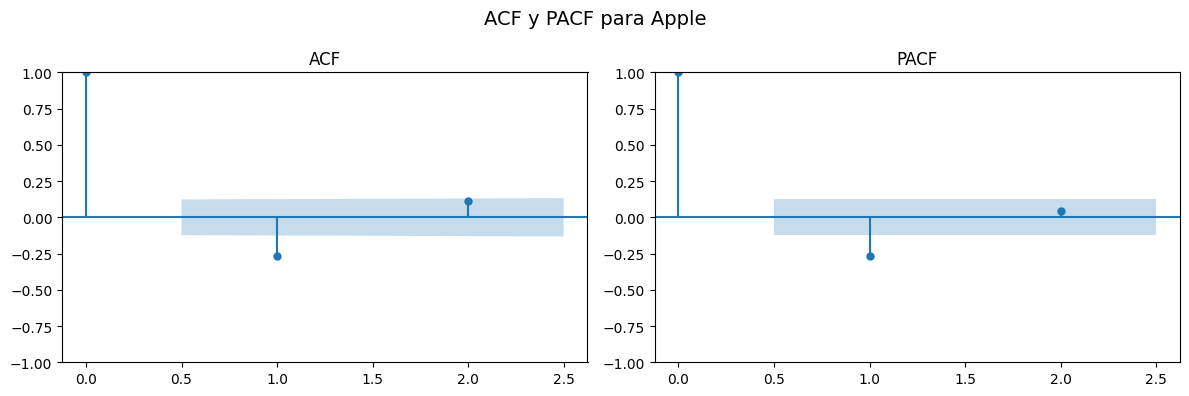

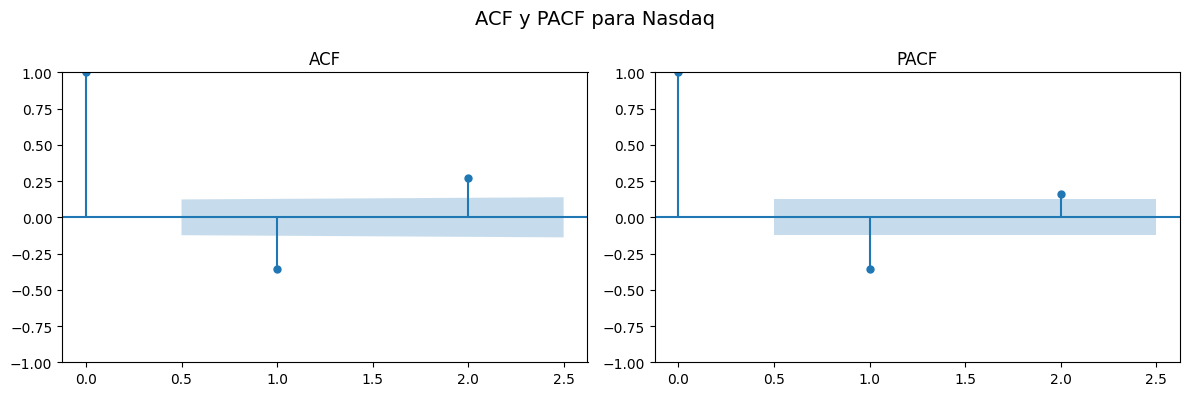

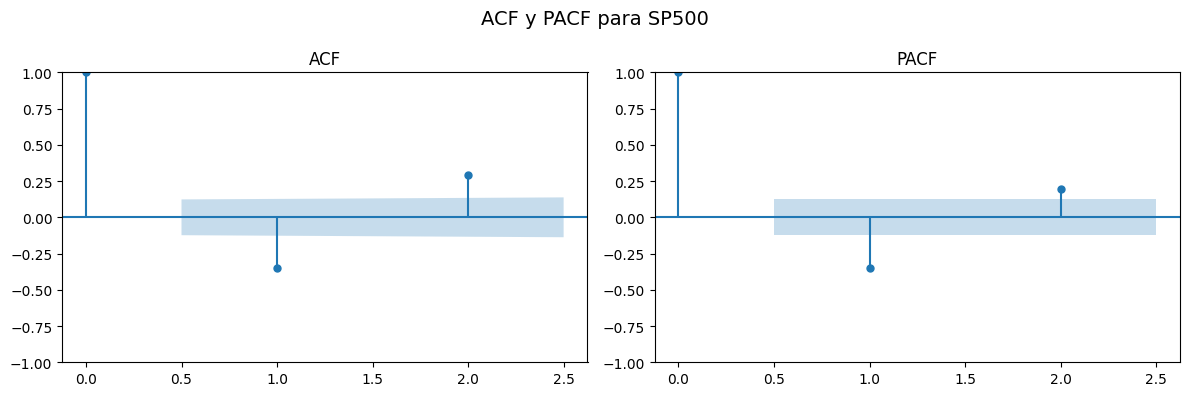

In [90]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

variables = log_diff_df.columns

for var in variables:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'ACF y PACF para {var}', fontsize=14)
    
    plot_acf(log_diff_df[var].dropna(), lags=2, ax=axes[0])
    plot_pacf(log_diff_df[var].dropna(), lags=2, ax=axes[1], method='ywm')
    
    axes[0].set_title('ACF')
    axes[1].set_title('PACF')
    
    plt.tight_layout()
    plt.show()


En este caso, basados en las graficas, podemos observar que para Apple, el numero optimo de rezagos es de dos, por tanto, utilizaremos esta cantidad para estimar el modelo

In [92]:
p_optimo = 2

In [93]:
modelo = VAR(log_diff_df)
modelo_var = modelo.fit(p_optimo)
print(modelo_var.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 18, May, 2025
Time:                     10:15:07
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   -37.5539
Nobs:                     250.000    HQIC:                  -37.8569
Log likelihood:           3374.68    FPE:                2.95388e-17
AIC:                     -38.0610    Det(Omega_mle):     2.56421e-17
--------------------------------------------------------------------
Results for equation DJ30
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000339         0.001385            0.245           0.806
L1.DJ30           1.092182         0.438608            2.490           0.013
L1.Apple         -0.125603         0.103656           -1.212           0.226


/home/carlos/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


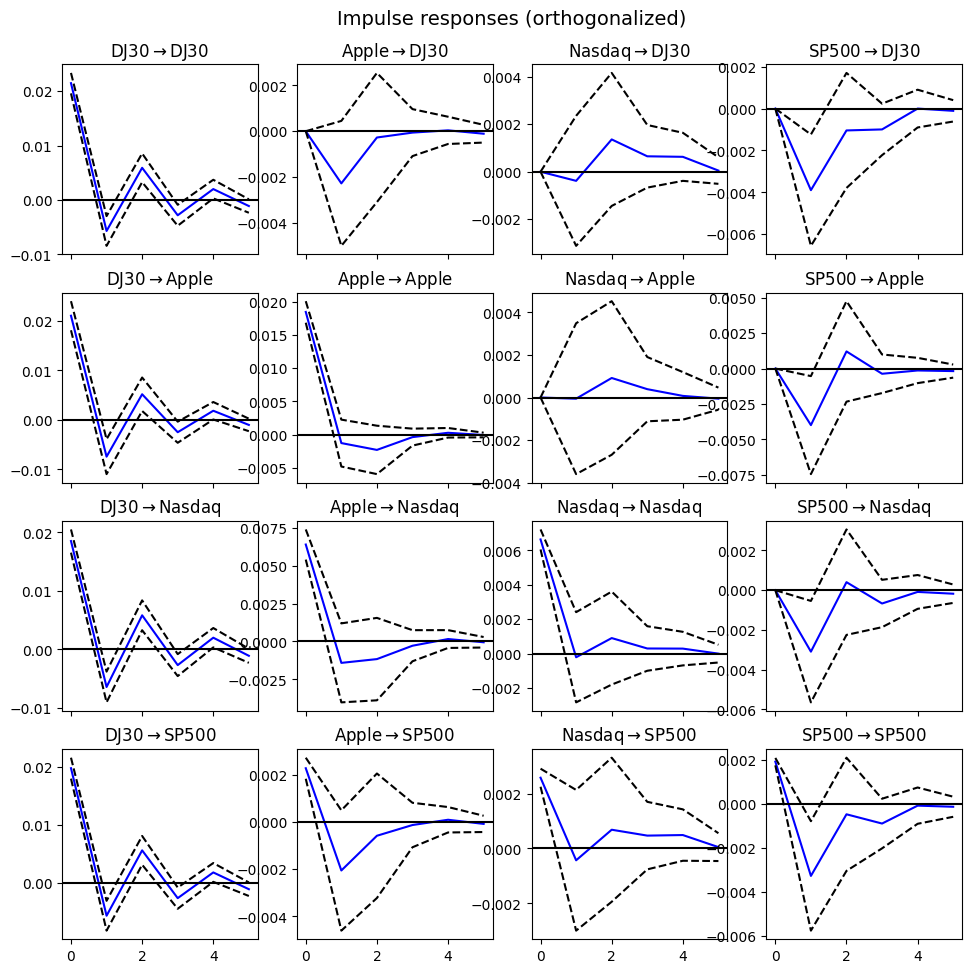

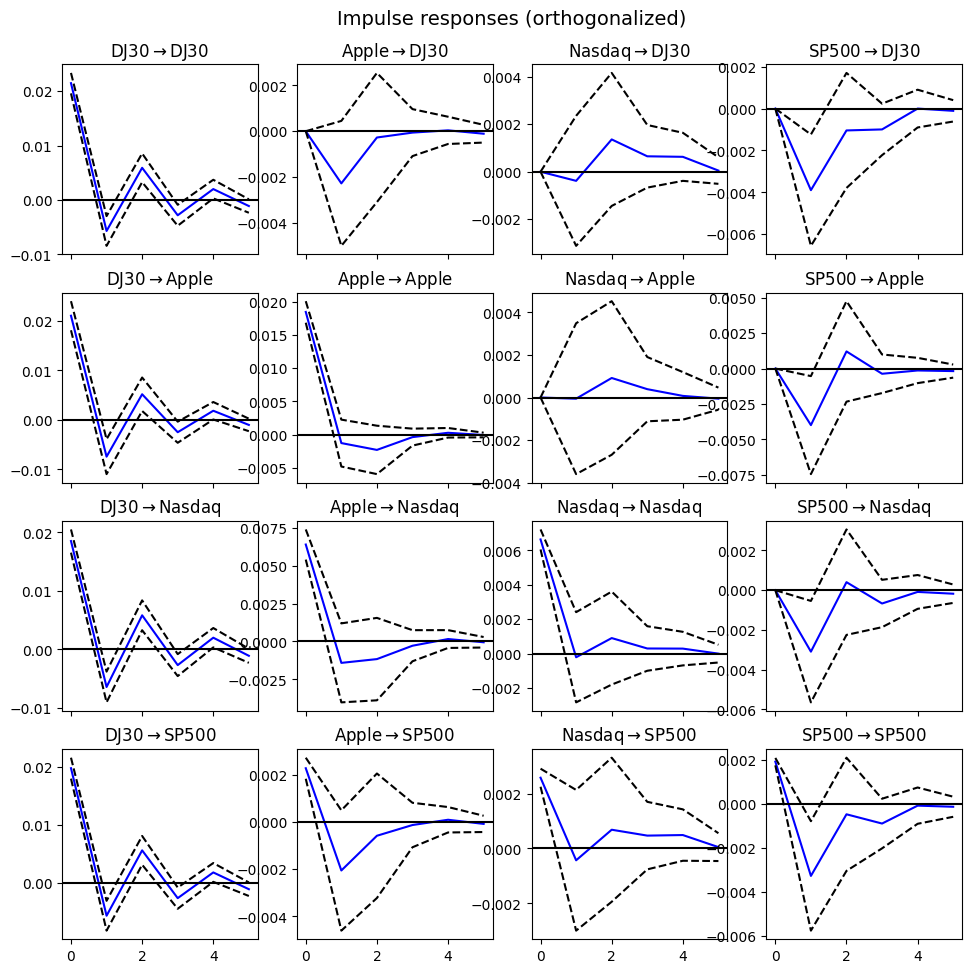

In [94]:
# Obtener y graficar la función impulso-respuesta para 10 periodos
irf = modelo_var.irf(5)
irf.plot(orth=True)


# Clase 5

Vamos a construir el modelo Garch para cada serie

In [95]:
modelos_garch = {}

for col in log_diff_df.columns:

    serie = log_diff_df[col].dropna() * 100
    modelo = arch_model(serie, vol='Garch', p=1, q=1, mean='Zero', dist='normal')
    resultado = modelo.fit(disp='off')
    
    print(resultado.summary())

    modelos_garch[col] = resultado


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   DJ30   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.004
Vol Model:                      GARCH   Log-Likelihood:               -463.376
Distribution:                  Normal   AIC:                           932.752
Method:            Maximum Likelihood   BIC:                           943.341
                                        No. Observations:                  252
Date:                Sun, May 18 2025   Df Residuals:                      252
Time:                        10:29:40   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1154  6.768e-02      1.705  8.814e-02 [-1.72

Ahora recuperaremos las varianzas para los modelos

In [106]:
log_diff_df

,DJ30,Apple,Nasdaq,SP500
Fecha,,,,
2020-01-03,-0.008136,-0.009769,-0.007886,-0.007085
2020-01-06,0.002389,0.007903,0.005604,0.003527
2020-01-07,-0.004179,-0.004681,-0.000318,-0.002807
2020-01-08,0.005631,0.015958,0.006667,0.004890
2020-01-09,0.007342,0.021018,0.008094,0.006633
...,...,...,...,...
2020-12-24,0.002322,0.007683,0.002629,0.003530
2020-12-28,0.006736,0.035141,0.007368,0.008685
2020-12-29,-0.002249,-0.013404,-0.003821,-0.002230


/home/carlos/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0005439. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/carlos/.local/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008632. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/carlos/.local/lib/python3.10/site-packages/arch/univariate

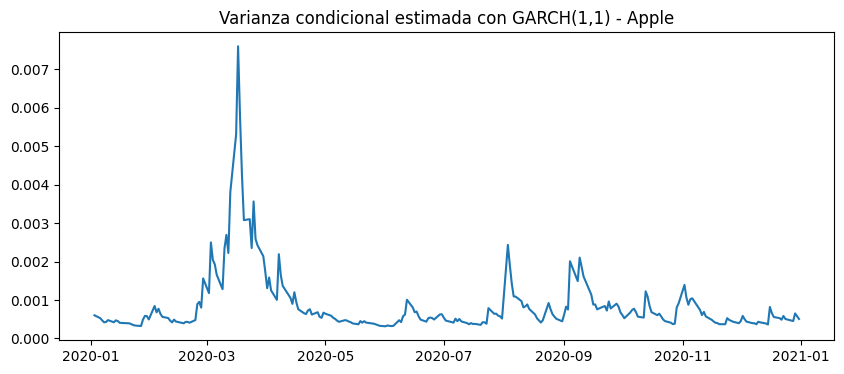

In [107]:
var_condicionales = pd.DataFrame(index=log_diff_df.index)

for col in log_diff_df.columns:
    am = arch_model(log_diff_df[col].dropna(), vol='Garch', p=1, q=1, mean='Zero')
    res = am.fit(disp='off')
    # La varianza condicional se encuentra en res.conditional_volatility**2
    var_condicionales[col] = res.conditional_volatility**2

# Graficar varianza condicional de Apple
plt.figure(figsize=(10,4))
plt.plot(var_condicionales['Apple'])
plt.title("Varianza condicional estimada con GARCH(1,1) - Apple")
plt.show()